In [1]:
import numpy as np
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import utils
from snntorch import surrogate
import torch.nn.functional as F
from snntorch import functional as SF
import brevitas.nn as qnn 

from tqdm import tqdm
import sys
sys.path.append('../src')
from RecurrentAHPC import RecurrentAhpc
from dataloader import WISDM_Dataset_parser, WISDM_Dataset
from torch.utils.data import  DataLoader
from assistant import Assistant
from stats import LearningStats
from utils import gen_confusion_matrix

In [2]:

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f'Using device {device}')

Using device cuda


In [3]:
batch_size = 512
# network parameters
num_inputs = 6 
num_steps = 40
num_hidden_1 = 128
num_hidden_2 = 256
num_hidden_3 = 128
num_outputs = 7
pop_outputs = num_outputs * 10
num_epochs = 200

# spiking neuron parameters
beta = 0.9  # neuron decay rate
grad = surrogate.fast_sigmoid()

In [4]:

dataset = WISDM_Dataset_parser('../data/watch_subset2_40.npz', norm=None)
train_set = dataset.get_training_set()
test_set = dataset.get_validation_set()

train_dataset = WISDM_Dataset(train_set)
test_dataset = WISDM_Dataset(test_set)

train_loader = DataLoader(dataset=train_dataset, batch_size=int(batch_size), shuffle=True, num_workers=8)
test_loader  = DataLoader(dataset= test_dataset, batch_size=int(batch_size), shuffle=True, num_workers=8)

(6,)
(6,)
num classes train dataset: 7 occurrences of each class:[3189 2987 3083 3262 3046 3071 3082]
num classes eval dataset: 7 occurrences of each class:[1050 1017  982  998 1058 1055 1080]
num classes test dataset: 7 occurrences of each class:[1031  948 1014 1076 1062 1038 1072]


In [5]:

class MyNetwork(nn.Module):
    def __init__(self, num_inputs, num_hidden_1, num_hidden_2, num_outputs, beta, grad):
        
        super(MyNetwork, self).__init__()

        self.linear1 = nn.Linear(num_inputs, num_hidden_1)

        self.leaky1 = snn.Leaky(beta=beta, spike_grad=grad,
                                learn_beta=True, learn_threshold=True)
        
        self.linear2 = nn.Linear(num_hidden_1, num_hidden_2)

        self.recurrent = RecurrentAhpc(beta, beta, spike_grad=grad, back_grad=grad,
                                       init_hidden=True, reset_delay=True, linear_features=num_hidden_2,
                                        learn_beta=True, learn_threshold=True, learn_recurrent=True)
        
        self.linear3 = nn.Linear(num_hidden_2, num_outputs)

        self.leaky2 = snn.Leaky(beta=beta, spike_grad=grad,
                                learn_beta=True, learn_threshold=True, output=True)

    def forward(self, data):
        spk_rec = []
        utils.reset(self)  # resets hidden states for all LIF neurons in net
        mem1 = self.leaky1.init_leaky()
        spk2, mem2 = self.recurrent.init_rleaky()
        mem3 = self.leaky2.init_leaky()

        for step in range(data.size(2)):
            x = self.linear1(data[:,:,step])
            x, _ = self.leaky1(x)
            x = self.linear2(x)
            spk1= self.recurrent(x)
            x = self.linear3(spk1)
            x, _ = self.leaky2(x)
            spk_rec.append(x)
        batch_out = torch.stack(spk_rec)
        # batch_out = batch_out.transpose(1, 0)
        return batch_out

# Create an instance of the network
net = MyNetwork(num_inputs, num_hidden_1, num_hidden_2, num_outputs, beta, grad).to(device)


In [6]:

def test_accuracy(data_loader, net, population_code=False, num_classes=False):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()

    tqdm_dataloader = tqdm(data_loader)
    for _, batch  in enumerate(tqdm_dataloader):
      data, targets = batch
      data = data.to(device)
      targets = targets.to(device)
      spk_rec = net(data)

      if population_code:
        acc += SF.accuracy_rate(spk_rec, targets, population_code=True, num_classes=num_outputs) * spk_rec.size(1)
      else:
        acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)

      total += spk_rec.size(1)
      tqdm_dataloader.set_description(f'\r[Test accuracy: {(acc/total)* 100:.2f}]')
  return acc/total

In [7]:
optimizer = torch.optim.Adam(net.parameters(), lr=2e-3, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
    T_max=4690, 
    eta_min=0, 
    last_epoch=-1
)
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2, num_classes=num_outputs, population_code=False)

In [8]:
stats = LearningStats()
assistant = Assistant(net, loss_fn, optimizer, stats, classifier=True, scheduler=scheduler)

In [9]:
count = 0
for epoch in range(num_epochs):
        labels = []
        outputs = []
        # if epoch % 20 == 0:
        #     assistant.reduce_lr()
        if count < 10:
            count = count+1
            tqdm_dataloader = tqdm(train_loader)
            for _, batch in enumerate(tqdm_dataloader): # training loop
                input, label = batch
                
                output = assistant.train(input, label)
                tqdm_dataloader.set_description(f'\r[Epoch {epoch:2d}/{num_epochs}] Training: {stats.training}')

            tqdm_dataloader = tqdm(test_loader)
            for _, batch in enumerate(tqdm_dataloader): #eval loop
                input, label = batch
                output = assistant.test(input, label)
                tqdm_dataloader.set_description(f'\r[Epoch {epoch:2d}/{num_epochs}] Validation: {stats.testing}')
            
                if len(outputs) == 0:
                    outputs = output.to('cpu').detach()
                    labels = label.to('cpu').detach()
                else:
                    outputs = torch.cat((outputs, output.to('cpu').detach()), dim=1)
                    labels = torch.cat((labels, label.to('cpu').detach()))


            stats.update()

            if stats.testing.best_accuracy:
                count = 0
                _, predictions = outputs.sum(dim=0).max(1)
                gen_confusion_matrix(predictions,labels, './')
                #torch.save(net.state_dict(), '/network.pt')
                stats.save('./')

            del outputs
            del labels

[Epoch  0/200] Training: loss =     2.00889                          accuracy = 0.20750 :  77%|███████▋  | 33/43 [00:05<00:01,  6.15it/s]


KeyboardInterrupt: 

In [ ]:
# train_acc_hist = []
# train_loss_hist = []
# test_loss_hist = []
# test_acc_hist = []

# for epoch in range(num_epochs):
#     tqdm_dataloader = tqdm(train_loader)
#     epoch_loss = []
#     curr_spk = []
#     curr_targets = []
#     for i, batch in enumerate(tqdm_dataloader):
#         data, targets = batch
#         data = data.to(device)
#         targets = targets.to(device)

#         net.train()
#         spk_rec =  net(data)
#         loss_val = loss_fn(spk_rec, targets)
#         # Gradient calculation + weight update
#         optimizer.zero_grad()
#         loss_val.backward()
#         optimizer.step()
#         scheduler.step()
#         if len(curr_spk) == 0:
#             curr_spk = spk_rec.to('cpu').detach()
#             curr_targets = targets.to('cpu').detach()
#         else:

#             curr_spk = torch.cat((curr_spk, spk_rec.to('cpu').detach()), dim=1)
#             curr_targets = torch.cat((curr_targets, targets.to('cpu').detach()))

#         # Store loss history for future plotting
#         epoch_loss.append(loss_val.item())
        
#         loss_mean = np.mean(epoch_loss)
#         acc = SF.accuracy_rate(curr_spk, curr_targets)
#         tqdm_dataloader.set_description(f'\r[Epoch {epoch:2d}/{num_epochs}] loss:{loss_mean:.2f} accuracy:{acc * 100:.2f}')
    
#     train_loss_hist.append(loss_mean)    
#     train_acc_hist.append(acc)

#     test_acc = test_accuracy(test_loader, net, num_steps, num_classes=num_outputs)
#     test_acc_hist.append(test_acc)
    


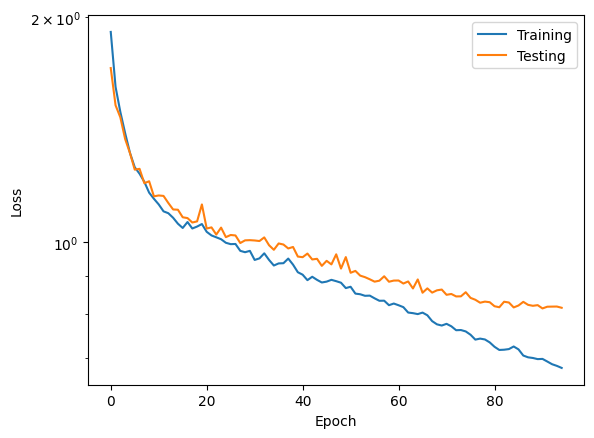

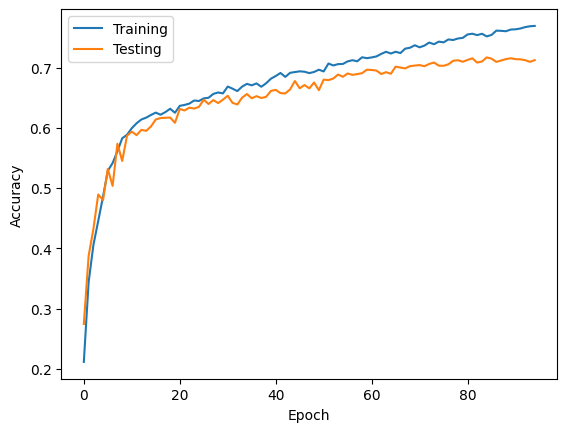

In [ ]:
stats.plot()